# w266: Final Project
### Christopher Danicic, Robert Deng, Chandan Gope
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
#Load libraries
import os, sys, re, json, time, gc, warnings
import itertools, collections
from importlib import reload
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import matplotlib.gridspec as gridspec 
import seaborn as sns
import string
from PIL import Image
color = sns.color_palette()

#SciKit
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#NLTK
import nltk
from nltk import pos_tag, pos_tag_sents
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer  

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

/home/deng_bobby/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/deng_bobby/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load data

In [2]:
#Load data
train = pd.read_csv("~/w266-data/train.csv")
test = pd.read_csv("~/w266-data/test.csv")

In [3]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


There's roughly a 50/50 split between test and train. Later, we will further segment 15% of the train data as dev data

### Exploratory Data Analysis

The data came clean with no traces of N/A's

In [4]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


Note that we have ~ 160K total comments, but ~143K clean comments, and ~35K tags, there must a heavy case of multilabeling.

In [5]:
x=train.iloc[:,2:].sum()
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)


print("Total Comments:", train.shape[0])
print("Total Clean Comments:", train.clean.sum())
print("Total tags:",x.sum())

Total Comments: 159571
Total Clean Comments: 143346
Total tags: 35098


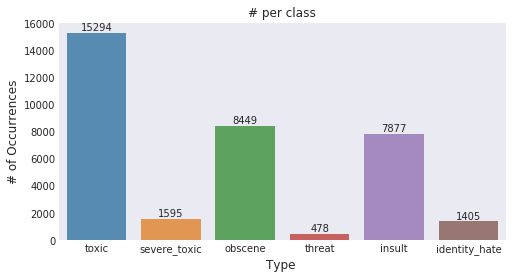

In [6]:
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

We might face class imbalance problems as toxicity is not evenly spread out across classes.

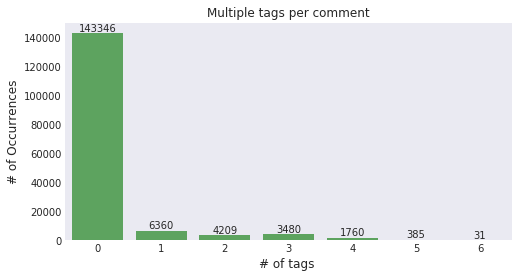

In [7]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

~150K comments were only single labeled and 2-3 labeled commends were comments were the most common afterwards. Next we want to understand which labels were most commonly tagged together. A Corr plot using Pearson's correlation below gives us an imperfect, directional perspective as the tag data was binary. The most correlated tags were:

-toxic <-> severe toxic

-toxic <-> insult

-obscene <-> insult

Also threat comments had the least amount of connection with other tags was "threat", maybe requiring specific features compared to others to classify.

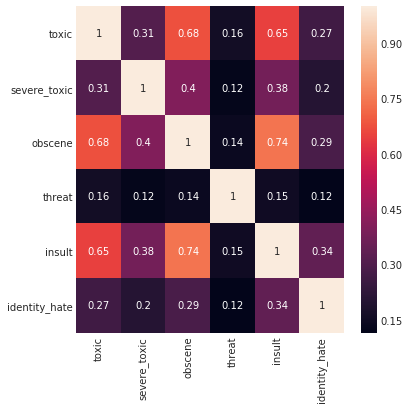

In [8]:
temp_df = train.iloc[:,2:-1]
corr=temp_df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

#### Next, looking at a crosstab count of binary features reveals that all severe_toxic comments were also toxic_comments. We now question the necessity of severe_toxic and its severity. 

In [9]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)
    
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

#### Example Comments

In [10]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [11]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [12]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [13]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [14]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


# Feature Generation

We begin feature generation by merging our train and test datasets for vectorization

In [15]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)
df.head()

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."


In [16]:
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [17]:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [20]:
df.describe()

,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
count,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000,312734.000000,312734.000000,312734.000000
mean,3.564347,64.500145,45.895208,379.773262,16.994561,3.128742,8.076541,28.067834,4.971746,85.670376,35.622062
std,7.401605,99.138334,53.702224,591.767791,43.638134,25.050917,17.028582,43.954539,7.247675,13.062229,297.488715
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.059988,0.000000
25%,1.000000,15.000000,14.000000,87.000000,4.000000,0.000000,2.000000,6.000000,4.294118,78.350515,16.363636
50%,2.000000,34.000000,29.000000,193.000000,9.000000,1.000000,4.000000,14.000000,4.680000,87.500000,24.489796
75%,3.000000,71.000000,56.000000,414.000000,18.000000,2.000000,9.000000,32.000000,5.102564,95.833333,37.500000
max,699.000000,2321.000000,821.000000,5000.000000,4965.000000,2142.000000,2142.000000,1667.000000,1655.000000,100.000000,99300.000000


In [21]:
#Resplit to train and testb
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

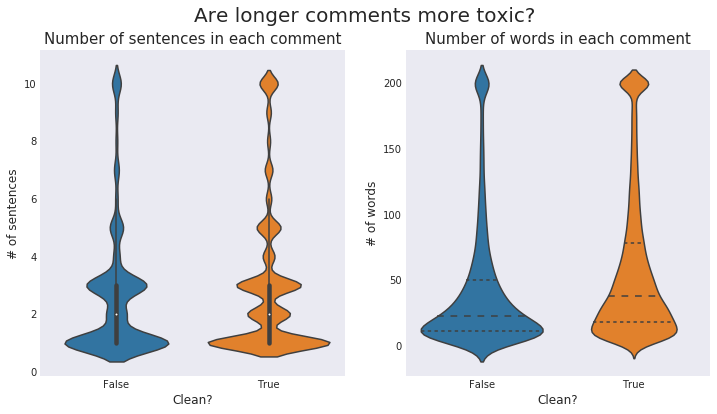

In [22]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.

Chart desc: Violin plot is an alternative to the traditional box plot. The inner markings show the percentiles while the width of the "violin" shows the volume of comments at that level/instance.

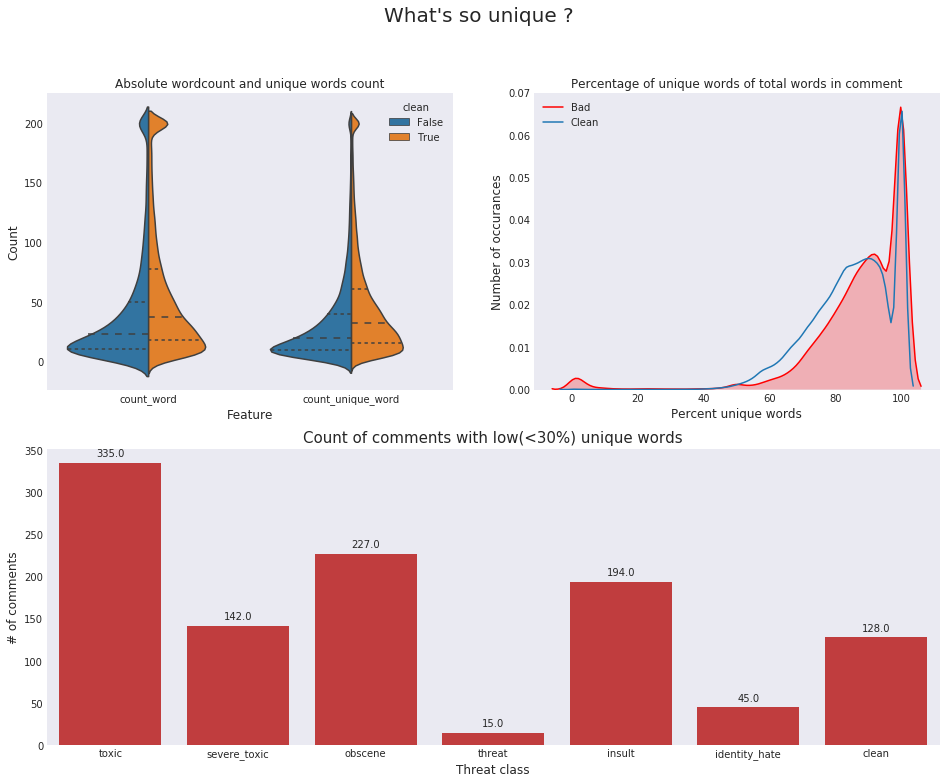

In [23]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 30% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

### Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.
   * Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
   
### Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.
   * Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments

Even though the number of clean comments dominates the dataset(~90%), there are only 75 clean comments that are spam, which makes it a powerful indicator of a toxic comment.

# Spammers are more toxic!
People who don't use a rich, diverse vocabulary (< 30% unique vocabular). Let's take a look at some clean and toxic spam messages

In [26]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

In [27]:
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Toxic Spam example:
User:NHRHS2010 is a homo like mitt romney is. 
User:NHRHS2010 is a homo like mitt romney is.
 User:Enigmaman is a homo like mitt romney is. 
User:Enigmaman is a homo like mitt romney is.
 User:NHRHS2010 is a homo like mitt romney is. 
User:NHRHS2010 is a homo like mitt romney is.
 User:Enigmaman is a homo like mitt romney is. 
User:Enigmaman is a homo like mitt romney is.== User:NHRHS2010 is a homo like mitt romney is. ==
User:NHRHS2010 is a homo like mitt romney is.
 User:Enigmaman is a homo like mitt romney is. 
User:Enigmaman is a homo like mitt romney is.== User:NHRHS2010 is a homo like mitt romney is. ==
User:NHRHS2010 is a homo like mitt romney is.
 User:Enigmaman is a homo like mitt romney is. 
User:Enigmaman is a homo like mitt romney is.== User:NHRHS2010 is a homo like mitt romney is. ==
User:NHRHS2010 is a homo like mitt romney is.
 User:Enigmaman is a homo like mitt romney is. 
User:Enigmaman is a homo like mitt romney is.== User:NHRHS2010 is a homo like 

In [28]:
#Leaky features
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#links
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

#username
##              regex for     Match anything with [[User: ---------- ]]
# regexp = re.compile("\[\[User:(.*)\|")
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))
#check if features are created
#df.username[df.count_usernames>0]

# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))


# Leaky usernames
cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [29]:
df[df.count_usernames!=0].comment_text.iloc[1]

'"\n\nWhat chart are you looking at?  I don\'t see anything portraying that timing. [[User talk:Spinningspark|Spark]]\'\'\' "'

In [32]:
cv.get_feature_names()[110:120]

['danielfolsom',
 'dante',
 'datbitch',
 'dc',
 'ddstretch',
 'de',
 'december',
 'deiz',
 'deltaquad',
 'dennis']

Make sure these leaky features are relevant to the original dataset and problem. We look at the intersection of the features within the train and the test dataset as a measure of data leakage - the more overlap, the more we're relying on data outside our training set to train. With the exception of common links, ip's and usernames appear to have minimal overlap and leakage.

In [31]:
leaky_feats=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]

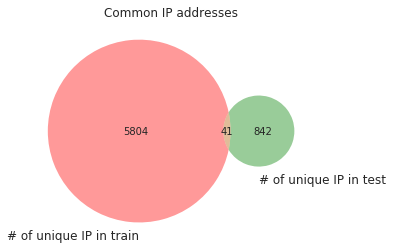

In [33]:
#filterout the entries without ips
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
#get the unique list of ips in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),set_labels=("# of unique IP in train","# of unique IP in test"))
plt.show()

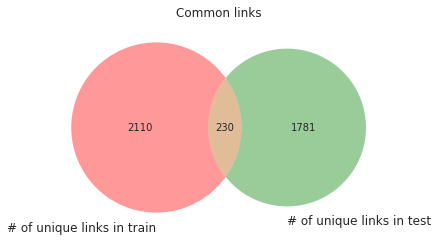

In [34]:
#filterout the entries without links
train_links=leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_links!=0]
#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common links")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)),
           set_labels=("# of unique links in train","# of unique links in test"))
plt.show()

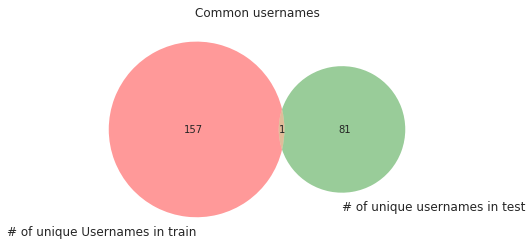

In [35]:
#filterout the entries without users
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique Usernames in train","# of unique usernames in test"))
plt.show()

**Vectorizing Comments**

We believe that the titles and request body should be treated separately. We will do so by building a preprocessor that includes NLTK capabilities along with regular expression cleaning.
1. Regular Expressions: cleaning out sequences of numbers, non-letter characters, strings with underscores, and lower-casing
2. Tokenizing: splits raw text into sentences, words and punctuation
3. Stop Words: removing filler words i.e. the, me, then
4. Pos Tag: use tokenized words to identify the part of speech WordNet tag from Penn Treebank https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
5. Lemmatizing: Convert the part of speech WordNet tag to identify a noun, verb, adverb, or adjective (based on starting with 'N’, ‘V’, ‘R’, or ‘J’). Then we use the tag to translate to the lemma, or the root word in the english lexicon.

In [120]:
#download all nltk corpora and data if you don't have it already
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [35]:
def nltk_preprocess(data):
    '''This function preprocesses a data frame, specifing a text_column, 
    and strips down the document to cleaned, individualized word tokens without
    stop words and other excessive parts of speech and eventually rejoins the remaining words.
    '''
    #Initializes stop words and new column creation
    stop = stopwords.words('english')
    
    
    #Initialize Lemmatizer object and final list of lemmatized words
    lemmatizer = WordNetLemmatizer()
    
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None # for easy if-statement
        
    def lemmatized(word, tag):
        wntag = get_wordnet_pos(tag)
        if wntag is None:
            lemma = str(lemmatizer.lemmatize(word))
        else:
            lemma = str(lemmatizer.lemmatize(word, pos=wntag))
        return lemma

    #Remove numeric data, alpha nonnumeric symbols, ip address, new lines, and usernames
    data = data.apply(lambda z: re.sub(r'\d+', r' ', z))
    data = data.apply(lambda z: re.sub(r'\W+', r' ', z))
    data = data.apply(lambda z: re.sub(r"_+",r" ", z))
    data = data.apply(lambda z: re.sub("\\n","", z))
    data = data.apply(lambda z: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","", z))
    data = data.apply(lambda z: re.sub("\[\[.*\]","", z))
    
    #Decapitalize, NLTK: tokenize, remove stop words, keep relevant pos tags, and lemmatize
    data = data.str.lower()
    data = data.apply(word_tokenize)
    data = data.apply(lambda x: [item for item in x if item not in stop])
    data = data.apply(pos_tag)
    data = data.apply(lambda x: [lemmatized(word, tag) for (word, tag) in x])
    data = data.apply(lambda x: ' '.join(x))
    return data

In [45]:
corpus=merge.comment_text

APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [46]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [47]:
start_time=time.time()
clean_corpus=corpus.apply(lambda x :clean(x))
end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 1324.9861862659454


In [48]:
corpus.iloc[1234]

'Will you be archiving NWS and SPC maps from today and tomorrow to include on the page? Do you think it would be a good idea? ~'

In [49]:
clean_corpus.iloc[1234]

'archive nws spc map today tomorrow include page ? think would good idea ? ~'

In [50]:
train_tags=train.iloc[:,2:]

In [51]:
start_unigrams=time.time()
tfv = TfidfVectorizer(max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [55]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

# Modelling

In [133]:
#Modelling
#Seeding
np.random.seed(6)
in_dev = np.random.choice([True, False], len(train), p=[0.15, 0.85])

#Train
train_data = train.comment_text[np.logical_not(in_dev)]
train_labels = train.iloc[np.logical_not(in_dev), 2:8]

#Dev Set
dev_data, dev_labels = train.comment_text[in_dev], train.iloc[in_dev, 2:8]

#Target Names
target_names = train.columns[2:8]

#Print some train data
print("train_text", train_data.shape, "\ntrain_labels", train_labels.shape)
print("\n\ndev_text", dev_data.shape, "\ndev_labels", dev_labels.shape)
train.head(n=20)

train_text (135526,) 
train_labels (135526, 6)


dev_text (24045,) 
dev_labels (24045, 6)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [91]:
toxic_pipeline = Pipeline([('cv', CountVectorizer()),
                           ('tfidf', TfidfTransformer()),
                           ('dtc', DecisionTreeClassifier())])

#toxic_pipeline_2 = Pipeline([('cv', CountVectorizer()), ('tfidf', TfidfTransformer()), ('svc', OneVsRestClassifier(LinearSVC(multi_class="ovr")))])


toxic_pipeline.fit(preprocessed_train_data, train_labels)
#toxic_pipeline_2.fit(preprocessed_train_data, train_labels)

Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [22]:
toxic_pipeline_2 = Pipeline([('cv', CountVectorizer()),
                           ('tfidf', TfidfTransformer()),
                           ('svc', OneVsRestClassifier(LinearSVC(multi_class="ovr")))])
toxic_pipeline_2.fit(preprocessed_train_data, train_labels)
pred_dev_2 = toxic_pipeline_2.predict(dev_data)
print(classification_report(pred_dev_2, dev_labels, target_names = target_names))

               precision    recall  f1-score   support

        toxic       0.57      0.61      0.59      2162
 severe_toxic       0.22      0.65      0.33        79
      obscene       0.64      0.59      0.61      1342
       threat       0.08      0.75      0.14         8
       insult       0.43      0.80      0.56       619
identity_hate       0.14      0.74      0.23        38

  avg / total       0.56      0.63      0.58      4248



In [14]:
pred_dev = toxic_pipeline.predict(dev_data)
pred_dev_2 = toxic_pipeline_2.predict(dev_data)
print(classification_report(pred_dev, dev_labels, target_names = target_names))
print(classification_report(pred_dev_2, dev_labels, target_names = target_names))

               precision    recall  f1-score   support

        toxic       0.58      0.24      0.34      5637
 severe_toxic       0.13      0.26      0.17       116
      obscene       0.67      0.27      0.38      3062
       threat       0.12      0.23      0.16        39
       insult       0.50      0.22      0.30      2700
identity_hate       0.17      0.18      0.17       189

  avg / total       0.57      0.24      0.34     11743

               precision    recall  f1-score   support

        toxic       0.57      0.61      0.59      2162
 severe_toxic       0.22      0.65      0.33        79
      obscene       0.64      0.59      0.61      1342
       threat       0.08      0.75      0.14         8
       insult       0.43      0.80      0.56       619
identity_hate       0.14      0.74      0.23        38

  avg / total       0.56      0.63      0.58      4248



In [21]:
pred_train = toxic_pipeline.predict(train_data)
pred_train_2 = toxic_pipeline_2.predict(train_data)
print(classification_report(pred_train, train_labels, target_names = target_names))
print(classification_report(pred_train_2, train_labels, target_names = target_names))

               precision    recall  f1-score   support

        toxic       0.71      0.29      0.41     32432
 severe_toxic       0.47      0.68      0.56       951
      obscene       0.74      0.32      0.44     16915
       threat       0.33      0.56      0.42       241
       insult       0.64      0.29      0.39     15011
identity_hate       0.47      0.45      0.46      1246

  avg / total       0.69      0.30      0.42     66796

               precision    recall  f1-score   support

        toxic       0.69      0.70      0.70     12842
 severe_toxic       0.35      0.86      0.50       562
      obscene       0.75      0.67      0.71      8063
       threat       0.20      0.94      0.33        86
       insult       0.59      0.92      0.72      4332
identity_hate       0.31      0.95      0.46       388

  avg / total       0.68      0.73      0.69     26273



In [17]:
pred_test = toxic_pipeline.predict(test)
pred_test_2 = toxic_pipeline_2.predict(test)

In [20]:
len(cv.get_feature_names())

146228

In [16]:
cv = CountVectorizer(min_df = 1)
ctv = cv.fit_transform(preprocessed_train_data)
ctv_freq = pd.DataFrame({'term': cv.get_feature_names(), 'occurrences':np.asarray(ctv.sum(axis=0)).ravel().tolist()})
ctv_freq['frequency'] = ctv_freq['occurrences']/ctv_freq.shape[0]
print (ctv_freq.sort_values('frequency', ascending = False).head(100))

        occurrences       term  frequency
7931          63087    article   0.431429
92724         48729       page   0.333240
139676        41448  wikipedia   0.283448
124123        34331       talk   0.234777
133963        27537        use   0.188316
37999         26265       edit   0.179617
90535         26127        one   0.178673
76057         25537       make   0.174638
97164         25355     please   0.173394
141125        25020      would   0.171103
72979         24432       like   0.167082
111195        21752        say   0.148754
112540        21663        see   0.148145
126754        20929      think   0.143126
69132         20205       know   0.138175
118089        20174     source   0.137963
49758         19180        get   0.131165
50796         18377         go   0.125674
4214          17458       also   0.119389
127509        16465       time   0.112598
94889         16105     people   0.110136
1389          16097        add   0.110082
133995        15739       user   0

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = [‘red’ if c < 0 else ‘blue’ for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha=’right’)
    plt.show()

cv = CountVectorizer()
train = cv.fit_transform(preprocessed_train_data)


svm = OneVsRestClassifier(LinearSVC(multi_class="ovr")
svm.fit(X_train, target)
plot_coefficients(svm, cv.get_feature_names())